In [1]:
%load_ext autoreload
%autoreload 2

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Current device:", device)

RANDOM_SEED = [1,2,3,4,5,6,7,4399,114514,1234]
# RANDOM_SEED = [1]
BATCH_SIZE = 32
LEARN_RATE = 0.001
MAX_NUM_EPOCH = 200
VISUALIZE_MODEL = False

Current device: cuda


In [2]:
from models.CAE import CNN1D
from torchview import draw_graph

model = CNN1D()
model.to(device)

if VISUALIZE_MODEL:
    model_graph = draw_graph(
        model,
        input_size=[(BATCH_SIZE, 84), (BATCH_SIZE, 4)],
        expand_nested=True)
    display(model_graph.visual_graph)

Outcome Columns: Index(['Diagnosis', 'FEV1', 'FEV1/FVC', 'FEF2575', 'FEV1_pred',
       'FEV1/FVC_pred', 'FEF2575_pred', 'R5', 'R5_20', 'R20', 'X5', 'AX', 'TV',
       'R5_z_score', 'R5_20_z_score', 'R20_z_score', 'X5_z_score',
       'AX_z_score'],
      dtype='object')
Info Columns: Index(['ID', 'Trial', 'Age', 'Sex', 'Height', 'Weight', 'OralCavity', 'OPJ',
       'Glottis', 'Carina'],
      dtype='object')
# of total CSA samples: 1058
# of total subjects: 340


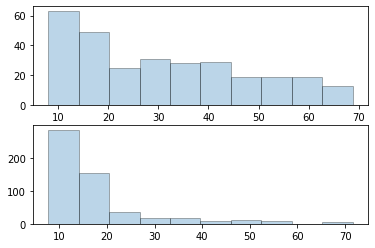

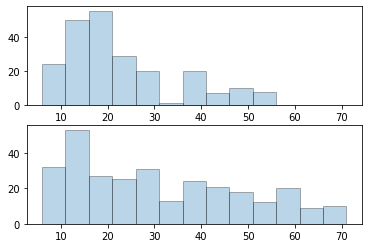

# of valid CSA samples w/o NaN: 524
# of subjects w/ valid CSA samples: 212
# of healthy samples: 295
# of asthma sampels: 229


In [3]:
from data.aware import AwareDataset, AwareSplitter
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

dataset = AwareDataset(
    csv_data = 'data/exhale_data_v8_ave.csv',
    csv_outcome = 'data/exhale_outcome_v8_ave.csv',
    csv_info = 'data/exhale_verbose_v8_ave.csv',
    root_dir = 'data/',
    target_classes = [0,1],
    partially_remove = True
)

class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(dataset.data_out['Diagnosis']), 
    y=dataset.data_out['Diagnosis']
)

In [4]:
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output
import time
import jupyter_beeper

from trainer.pretrain import PreTrainer
from trainer.finetune import FineTuner
from utils.others import weight_reset, Metrics, Outputs
from utils.clustering import evaluate
from utils.outlier import novelty_detection

# metrics_cluster = np.zeros((5,3,3))
metrics_val = Metrics()
metrics_test = Metrics()
outputs_test = Outputs()
ig_test = torch.Tensor([])

beeper = jupyter_beeper.Beeper()

for rand_seed in RANDOM_SEED:
    splitter = AwareSplitter(dataset, BATCH_SIZE, random_seed=rand_seed)

    timestr = time.strftime("%Y%m%d-%H%M%S")
    for split_idx, (train_loader, val_loader, test_loader) in enumerate(splitter):
        writer = SummaryWriter("runs/" + timestr + "-fold" + str(split_idx))
        model.apply(weight_reset)
        
#         clear_output(wait=True)
        print("Seed " + str(rand_seed) + " | Fold #" + str(split_idx) + " | Pre-training...")
        model.pre_train()
        pre_trainer = PreTrainer(
            model,
            lr = LEARN_RATE,
            T_max = MAX_NUM_EPOCH,
            device = device,
            summarywriter = writer
        )
        for epoch in tqdm(range(MAX_NUM_EPOCH), unit_scale=True, unit="epoch"):
            pre_trainer.train(epoch, train_loader)
            pre_trainer.validate(epoch, val_loader)
        pre_trainer.test(val_loader, no_print=True)
        
#         clear_output(wait=True)
        print("Seed " + str(rand_seed) + " | Fold #" + str(split_idx) + " | Fine-tuning...")
        model.fine_tune()
        fine_tuner = FineTuner(
            model,
            lr = LEARN_RATE,
            T_max = MAX_NUM_EPOCH,
            device = device,
            summarywriter = writer,
            class_weights = torch.Tensor(class_weights)
        )
        for epoch in tqdm(range(MAX_NUM_EPOCH), unit_scale=True, unit="epoch"):
            fine_tuner.train(epoch, train_loader)
            fine_tuner.validate(epoch, val_loader)
        print("Validataion:")
        fine_tuner.test(val_loader, no_print=True)
        metrics_val.append_from(fine_tuner)
        print("Test:")
        fine_tuner.test(test_loader, no_print=True, calculate_ig=True)
        metrics_test.append_from(fine_tuner)
        outputs_test.append_from(fine_tuner)
        ig_test = torch.concat((ig_test, fine_tuner.attr_ig), dim=0)
        print()

#     beeper.beep(frequency=600, secs=0.5)
#     novelty_detection(model, train_loader, val_loader, test_loader)
#     metrics_cluster[split_idx,:,:] = evaluate(model, train_loader, val_loader, test_loader)    


Seed 1 | Fold #0 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 1 | Fold #0 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 1 | Fold #1 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 1 | Fold #1 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 1 | Fold #2 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 1 | Fold #2 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 1 | Fold #3 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 1 | Fold #3 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 1 | Fold #4 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 1 | Fold #4 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 2 | Fold #0 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 2 | Fold #0 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 2 | Fold #1 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 2 | Fold #1 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 2 | Fold #2 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 2 | Fold #2 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 2 | Fold #3 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 2 | Fold #3 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 2 | Fold #4 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 2 | Fold #4 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 3 | Fold #0 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 3 | Fold #0 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 3 | Fold #1 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 3 | Fold #1 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 3 | Fold #2 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 3 | Fold #2 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 3 | Fold #3 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 3 | Fold #3 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 3 | Fold #4 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 3 | Fold #4 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 4 | Fold #0 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 4 | Fold #0 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 4 | Fold #1 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 4 | Fold #1 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 4 | Fold #2 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 4 | Fold #2 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 4 | Fold #3 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 4 | Fold #3 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 4 | Fold #4 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 4 | Fold #4 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 5 | Fold #0 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 5 | Fold #0 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 5 | Fold #1 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 5 | Fold #1 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 5 | Fold #2 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 5 | Fold #2 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 5 | Fold #3 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 5 | Fold #3 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 5 | Fold #4 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 5 | Fold #4 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 6 | Fold #0 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 6 | Fold #0 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 6 | Fold #1 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 6 | Fold #1 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 6 | Fold #2 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 6 | Fold #2 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 6 | Fold #3 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 6 | Fold #3 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 6 | Fold #4 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 6 | Fold #4 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 7 | Fold #0 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 7 | Fold #0 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 7 | Fold #1 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 7 | Fold #1 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 7 | Fold #2 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 7 | Fold #2 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 7 | Fold #3 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 7 | Fold #3 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 7 | Fold #4 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 7 | Fold #4 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 4399 | Fold #0 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 4399 | Fold #0 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 4399 | Fold #1 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 4399 | Fold #1 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 4399 | Fold #2 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 4399 | Fold #2 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 4399 | Fold #3 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 4399 | Fold #3 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 4399 | Fold #4 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 4399 | Fold #4 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 114514 | Fold #0 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 114514 | Fold #0 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 114514 | Fold #1 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 114514 | Fold #1 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 114514 | Fold #2 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 114514 | Fold #2 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 114514 | Fold #3 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 114514 | Fold #3 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 114514 | Fold #4 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 114514 | Fold #4 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 1234 | Fold #0 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 1234 | Fold #0 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 1234 | Fold #1 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 1234 | Fold #1 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 1234 | Fold #2 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 1234 | Fold #2 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 1234 | Fold #3 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 1234 | Fold #3 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:

Seed 1234 | Fold #4 | Pre-training...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Seed 1234 | Fold #4 | Fine-tuning...


  0%|          | 0.00/200 [00:00<?, ?epoch/s]

Validataion:
Test:



In [5]:
print(ig_test.size())
print("Final Validation Results")
display(metrics_val)
print()
print("Final Test Results")
display(metrics_test)
print()
beeper.beep(frequency=600, secs=0.5)

torch.Size([5225, 88])
Final Validation Results


,Accuracy,Balanced_Acc,Sensitivity,Specificity,AUROC,FEV1,FEV1/FVC
0,0.694118,0.696844,0.465116,0.928571,0.649502,2.014148,2.498660
1,0.736842,0.696145,0.555556,0.836735,0.718821,0.155088,0.094923
2,0.551724,0.568627,0.666667,0.470588,0.453704,0.185408,0.122474
3,0.586207,0.660377,1.000000,0.320755,0.558824,0.220622,0.167815
4,0.688889,0.682815,0.648649,0.716981,0.687914,0.149958,0.132355
5,0.750000,0.774725,0.857143,0.692308,0.642170,0.185570,0.157980
6,0.675676,0.690421,0.758621,0.622222,0.682759,0.137945,0.093440
7,0.617021,0.643810,0.433962,0.853659,0.611597,0.175906,0.152993
8,0.682353,0.641329,0.324324,0.958333,0.717342,0.201231,0.138981
9,0.673913,0.644016,0.529412,0.758621,0.679006,0.163179,0.097260



Final Test Results


,Accuracy,Balanced_Acc,Sensitivity,Specificity,AUROC,FEV1,FEV1/FVC
0,0.616162,0.627455,0.403846,0.851064,0.679624,1.811083,2.357644
1,0.585859,0.595540,0.403846,0.787234,0.710311,0.171505,0.107247
2,0.616162,0.614157,0.653846,0.574468,0.670622,0.180193,0.137818
3,0.626263,0.610475,0.923077,0.297872,0.650982,0.185932,0.150537
4,0.646465,0.646072,0.653846,0.638298,0.677578,0.175062,0.122788
5,0.585859,0.585784,0.583333,0.588235,0.533905,0.158853,0.129060
6,0.626263,0.623775,0.541667,0.705882,0.712418,0.121322,0.100023
7,0.555556,0.545956,0.229167,0.862745,0.685049,0.140996,0.115104
8,0.525253,0.510417,0.020833,1.000000,0.390931,0.138755,0.117329
9,0.656566,0.654412,0.583333,0.725490,0.706291,0.132499,0.110676


In [6]:
import pickle
with open('metrics_val.pkl', 'wb') as metrics_val_file:
    pickle.dump(metrics_val, metrics_val_file)
with open('metrics_test.pkl', 'wb') as metrics_test_file:
    pickle.dump(metrics_test, metrics_test_file)

1752 1253
838 1382


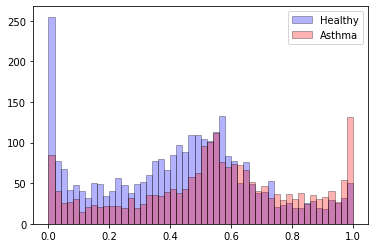

Sens: 0.6225225225225225
Spec: 0.5830282861896838
BalAcc: 0.6027754043561031


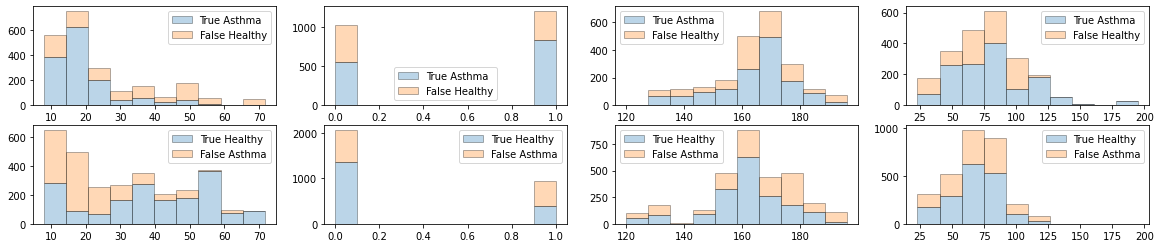

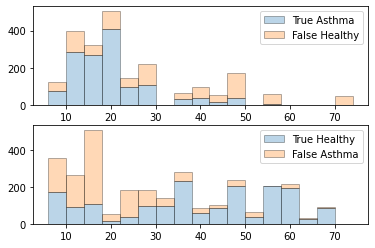

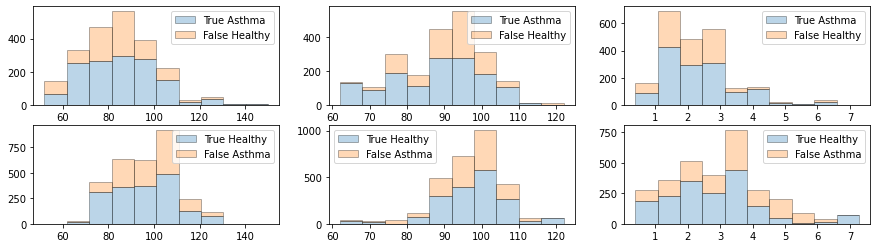

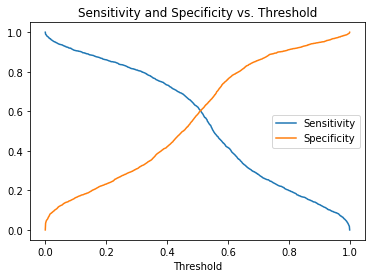

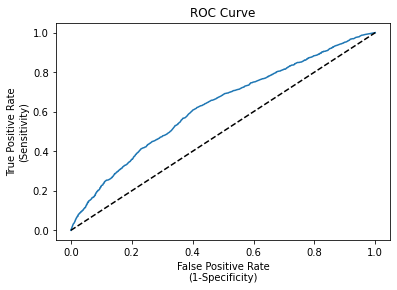

In [7]:
import ast
import matplotlib.pyplot as plt
import scikitplot as skplt
import pandas as pd

labels = outputs_test.outputs['Labels'].to_list()
labels = pd.DataFrame(labels)
labels.columns = ['Diagnosis', 'FEV1', 'FEV1/FVC', 'FEF2575', 'FEV1_pred',
       'FEV1/FVC_pred', 'FEF2575_pred', 'R5', 'R5_20', 'R20', 'X5', 'AX', 'TV',
       'R5_z_score', 'R5_20_z_score', 'R20_z_score', 'X5_z_score',
       'AX_z_score']

info = outputs_test.outputs['Info'].to_list()
info = pd.DataFrame(info)
info.columns = ['ID', 'Trial', 'Age', 'Sex', 'Height', 'Weight', 'OralCavity', 'OPJ',
       'Glottis', 'Carina']

meta = pd.concat([labels, info], axis=1)

outputs_cls = outputs_test.outputs['Outputs_cls'].to_list()
outputs_cls = pd.DataFrame(outputs_cls)

meta.insert(1, 'Prediction', np.exp(outputs_cls[1])/np.sum(np.exp(outputs_cls),axis=1))
meta.to_pickle('meta.pkl')

idx_tp = (meta['Diagnosis']==1) & (meta['Prediction']>=0.5)
tp = idx_tp.sum()
idx_fp = (meta['Diagnosis']==0) & (meta['Prediction']>=0.5)
fp = idx_fp.sum()
idx_tn = (meta['Diagnosis']==0) & (meta['Prediction']<0.5)
tn = idx_tn.sum()
idx_fn = (meta['Diagnosis']==1) & (meta['Prediction']<0.5)
fn = idx_fn.sum()
print(tn, fp)
print(fn, tp)

plt.figure()
plt.hist(meta['Prediction'][meta['Diagnosis']==0], bins=50, range=(0,1), alpha = 0.3, color='b', edgecolor='k', linewidth=1)
plt.hist(meta['Prediction'][meta['Diagnosis']==1], bins=50, range=(0,1), alpha = 0.3, color='r', edgecolor='k', linewidth=1)
plt.legend(['Healthy', 'Asthma'])
plt.show()

# cross_entropy = -(y_true*np.log10(y_pred[1]) + (1-y_true)*np.log10(y_pred[0]))

# plt.figure()
# # plt.hist(cross_entropy, bins=np.logspace(np.log10(0.1),np.log10(10.0), 50), edgecolor='k', linewidth=1)
# plt.hist(cross_entropy, bins=50, edgecolor='k', linewidth=1)
# plt.legend(['Healthy', 'Asthma'])
# # plt.gca().set_xscale("log")
# plt.vlines(-np.log10(0.5), 0, 500, color='r')
# plt.show()

# y_pred = y_pred.idxmax(axis=1)

sens = tp/(tp+fn)
spec = tn/(fp+tn)
print('Sens:', sens)
print('Spec:', spec)
print('BalAcc:', (sens+spec)/2)

plt.figure(figsize=(20,4))
plt.subplot(2,4,1)
plt.hist(pd.concat([meta['Age'][idx_tp], meta['Age'][idx_fn]], axis=1), range=(meta['Age'].min(),meta['Age'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,4,5)
plt.hist(pd.concat([meta['Age'][idx_tn], meta['Age'][idx_fp]], axis=1), range=(meta['Age'].min(),meta['Age'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.subplot(2,4,2)
plt.hist(pd.concat([meta['Sex'][idx_tp], meta['Sex'][idx_fn]], axis=1), range=(meta['Sex'].min(),meta['Sex'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,4,6)
plt.hist(pd.concat([meta['Sex'][idx_tn], meta['Sex'][idx_fp]], axis=1), range=(meta['Sex'].min(),meta['Sex'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.subplot(2,4,3)
plt.hist(pd.concat([meta['Height'][idx_tp], meta['Height'][idx_fn]], axis=1), range=(meta['Height'].min(),meta['Height'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,4,7)
plt.hist(pd.concat([meta['Height'][idx_tn], meta['Height'][idx_fp]], axis=1), range=(meta['Height'].min(),meta['Height'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.subplot(2,4,4)
plt.hist(pd.concat([meta['Weight'][idx_tp], meta['Weight'][idx_fn]], axis=1), range=(meta['Weight'].min(),meta['Weight'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,4,8)
plt.hist(pd.concat([meta['Weight'][idx_tn], meta['Weight'][idx_fp]], axis=1), range=(meta['Weight'].min(),meta['Weight'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.show()

plt.figure(figsize=(6,4))
plt.subplot(2,1,1)
plt.hist(pd.concat([meta['Age'][idx_tp], meta['Age'][idx_fn]], axis=1), bins=list(range(6,76,4)), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,1,2)
plt.hist(pd.concat([meta['Age'][idx_tn], meta['Age'][idx_fp]], axis=1), bins=list(range(6,76,4)), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.show()

plt.figure(figsize=(15,4))
plt.subplot(2,3,1)
plt.hist(pd.concat([meta['FEV1_pred'][idx_tp], meta['FEV1_pred'][idx_fn]], axis=1), range=(meta['FEV1_pred'].min(),meta['FEV1_pred'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,3,4)
plt.hist(pd.concat([meta['FEV1_pred'][idx_tn], meta['FEV1_pred'][idx_fp]], axis=1), range=(meta['FEV1_pred'].min(),meta['FEV1_pred'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.subplot(2,3,2)
plt.hist(pd.concat([meta['FEV1/FVC_pred'][idx_tp], meta['FEV1/FVC_pred'][idx_fn]], axis=1), range=(meta['FEV1/FVC_pred'].min(),meta['FEV1/FVC_pred'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,3,5)
plt.hist(pd.concat([meta['FEV1/FVC_pred'][idx_tn], meta['FEV1/FVC_pred'][idx_fp]], axis=1), range=(meta['FEV1/FVC_pred'].min(),meta['FEV1/FVC_pred'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.subplot(2,3,3)
plt.hist(pd.concat([meta['FEF2575'][idx_tp], meta['FEF2575'][idx_fn]], axis=1), range=(meta['FEF2575'].min(),meta['FEF2575'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Asthma', 'False Healthy'])
plt.subplot(2,3,6)
plt.hist(pd.concat([meta['FEF2575'][idx_tn], meta['FEF2575'][idx_fp]], axis=1), range=(meta['FEF2575'].min(),meta['FEF2575'].max()), alpha = 0.3, stacked=True, edgecolor='k', linewidth=1)
plt.legend(['True Healthy', 'False Asthma'])
plt.show()

thre = np.zeros(1001)
sens = np.zeros(1001)
spec = np.zeros(1001)
for i in range(0,1001):
    idx_tp = (meta['Diagnosis']==1) & (meta['Prediction']>=i/1000)
    tp = idx_tp.sum()
    idx_fp = (meta['Diagnosis']==0) & (meta['Prediction']>=i/1000)
    fp = idx_fp.sum()
    idx_tn = (meta['Diagnosis']==0) & (meta['Prediction']<i/1000)
    tn = idx_tn.sum()
    idx_fn = (meta['Diagnosis']==1) & (meta['Prediction']<i/1000)
    fn = idx_fn.sum()
    thre[i] = i/1000
    sens[i] = tp/(tp+fn)
    spec[i] = tn/(fp+tn)
    
plt.figure()
plt.plot(thre, sens)
plt.plot(thre, spec)
plt.title('Sensitivity and Specificity vs. Threshold')
plt.legend(['Sensitivity', 'Specificity'])
plt.xlabel('Threshold')
plt.show()

plt.figure()
# skplt.metrics.plot_roc_curve(meta['Diagnosis'], outputs_cls)
plt.plot(1-spec, sens)
plt.plot([0,1], [0,1], '--k')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate\n(1-Specificity)')
plt.ylabel('True Positive Rate\n(Sensitivity)')
plt.show()

tensor([-1.6589e-01, -2.8779e-02,  1.6387e-01, -1.0416e-01,  1.1179e-01,
        -4.6864e-02,  1.0710e-01,  4.5176e-02, -3.3359e-03,  1.3541e-02,
         1.0704e-01, -1.4340e-01, -7.6592e-03, -3.6698e-02,  8.1287e-03,
        -1.3776e-02, -1.6520e-02,  3.8761e-03, -3.1374e-02,  4.3294e-03,
        -2.1391e-02,  3.0607e-02, -1.2148e-01,  6.2856e-02,  1.6843e-02,
         4.6337e-02, -5.9003e-02,  6.2069e-02, -1.3233e-02,  1.0198e-01,
        -4.6425e-02, -6.8460e-03,  2.1482e-04,  1.8250e-02, -5.6566e-04,
        -1.8814e-02, -1.3743e-02, -2.1031e-02,  3.2131e-03, -6.4738e-03,
        -8.2839e-03, -7.2159e-03,  5.6714e-03, -6.7390e-03,  7.3553e-03,
        -6.0806e-03,  6.0891e-03,  7.9352e-04,  7.7163e-03, -1.5853e-02,
         2.9731e-03, -9.4535e-03,  5.0104e-03,  3.7092e-03,  1.1024e-02,
        -4.7130e-03,  5.2265e-03,  4.7065e-03,  1.0663e-02, -8.3389e-03,
         1.3045e-03, -1.5490e-02,  2.6827e-02, -4.0753e-02,  1.5396e-02,
        -1.2956e-02,  4.7908e-02, -3.6378e-02, -4.1

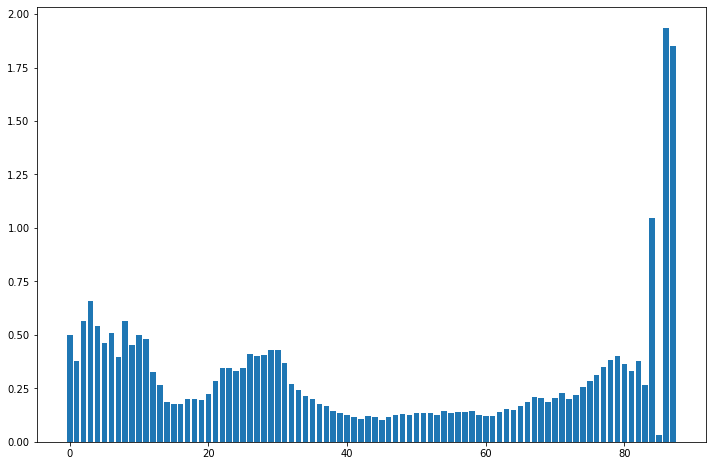

In [8]:
print(ig_test.mean(dim=0))
plt.figure(figsize=(12,8))
plt.bar(list(range(88)), ig_test.abs().mean(dim=0))
plt.show()